In [59]:
%matplotlib widget

from collections import deque

from solution import DIRECTION_VECTORS
from solution import Contestant
from solution import ContestantState
from solution import Coord
from solution import Direction
from solution import Entity
from solution import EntityKind
from solution import GameState
from solution import Node


# For testing with Jupyter
def read_game_state_from_file(path: str) -> tuple[int, int, GameState]:
    # Read entities and cache by uid without refrence to root or parent
    with open(path, "r") as buffer:
        width, height = [int(i) for i in buffer.readline().strip().split()]

        tmp_entities: dict[
            int, tuple[Entity, int | None, int | None]
        ] = {}  # uid: (entity, parent_uid, root_uid)
        for idx in range(int(buffer.readline().strip())):
            (
                _x,
                _y,
                _kind,
                _owner,
                _uid,
                _dir,
                _parent_uid,
                _root_uid,
            ) = buffer.readline().strip().split()

            _tmp_uid = int(_uid) if int(_uid) else (-idx)
            tmp_entities[_tmp_uid] = (
                Entity(
                    uid=_tmp_uid,
                    x=int(_x),
                    y=int(_y),
                    kind=EntityKind(_kind),
                    owner=None if _owner == "-1" else Contestant(_owner),
                    direction=Direction(_dir),
                    root=None,
                    parent=None,
                ),
                None if int(_parent_uid) == -1 else int(_parent_uid),
                None if int(_root_uid) == -1 else int(_root_uid),
            )

        # Process entities
        entities: dict[Coord, Entity] = {}
        roots: dict[Contestant, Entity] = {}

        for entity, parent_uid, root_uid in tmp_entities.values():
            if parent_uid:
                entity = entity.update_parent(tmp_entities[parent_uid][0])
            if root_uid:
                entity = entity.update_root(tmp_entities[root_uid][0])

            entities[entity.coord] = entity
            if entity.kind == EntityKind.ROOT and entity.owner:
                roots[entity.owner] = entity

        my_a, my_b, my_c, my_d = [int(i) for i in buffer.readline().strip().split()]
        player_state = ContestantState(
            root=roots[Contestant.PLAYER],
            protein_a=my_a,
            protein_b=my_b,
            protein_c=my_c,
            protein_d=my_d,
        )

        opp_a, opp_b, opp_c, opp_d = [int(i) for i in buffer.readline().strip().split()]
        opponent_state = ContestantState(
            root=roots[Contestant.OPPONENT],
            protein_a=opp_a,
            protein_b=opp_b,
            protein_c=opp_c,
            protein_d=opp_d,
        )

        required_actions_count = int(buffer.readline().strip())

        return (
            width,
            height,
            GameState(
                player=player_state,
                opponent=opponent_state,
                entities=entities,
                actions=required_actions_count,
            ),
        )


width, height, game_state = read_game_state_from_file("./inputs/wood_3.txt")
entities, player, opponent = game_state.entities, game_state.player, game_state.opponent


In [63]:
""" Step 1: build graph from the player root & capture features & possible strategies"""
nodes: dict[Coord, Node] = {
    # Initialize with the root node
    player.root.coord: Node(x=player.root.x, y=player.root.y, entity=player.root)
}
features: dict[Coord, Node] = {}
unvisited_coords: deque[Coord] = deque([player.root.coord])
visited_coords: set[Coord] = set()

while unvisited_coords:
    coord = unvisited_coords.popleft()
    if coord in visited_coords:
        continue

    x, y = coord
    node = nodes[coord]

    skip_children_and_features = any(
        [
            node.entity and node.entity.owner == Contestant.OPPONENT,
            node.entity and node.entity.kind in EntityKind.PROTEINS,
        ]
    )

    for direction, (i, j) in DIRECTION_VECTORS.items():
        c_x, c_y = coord[0] + i, coord[1] + j
        c_coord = (c_x, c_y)
        c_entity = entities.get(c_coord)

        if any(
            (
                c_x < 0 or c_x >= width,
                c_y < 0 or c_y >= height,
                c_entity and c_entity.kind == EntityKind.WALL,
            )
        ):
            continue

        if c_coord not in nodes and not skip_children_and_features:
            c_node = Node(x=c_x, y=c_y, entity=c_entity, parent=node)
            nodes[c_coord] = c_node
            unvisited_coords.append(c_coord)

            if True and any(
                [
                    # The node is empty
                    not c_entity,
                    # ... or the node is a player organism
                    c_entity
                    and c_entity.kind in EntityKind.ORGANISMS
                    and c_entity
                    and c_entity.owner
                    and c_entity.owner == Contestant.PLAYER,
                ]
            ):
                node.children.add(c_node)

            if any(
                [
                    # The feature is a protein
                    c_entity and c_entity.kind in EntityKind.PROTEINS,
                    # ... or the feature is an opponent organism
                    c_entity
                    and c_entity.kind in EntityKind.ORGANISMS
                    and c_entity.owner
                    and c_entity.owner == Contestant.OPPONENT,
                ]
            ):
                node.features[direction] = c_node
                features[coord] = c_node

    visited_coords.add(coord)

print("Features:")
for coord, node in features.items():
    print(f"{coord}: {node} ({node.entity.kind if node.entity else ''})")


Features:
(7, 5): <solution.Node object at 0x1739d7190> (EntityKind.PROTEIN_A)
(9, 4): <solution.Node object at 0x1739d58a0> (EntityKind.PROTEIN_A)
(11, 3): <solution.Node object at 0x1739d45b0> (EntityKind.BASIC)
(11, 4): <solution.Node object at 0x1739d6ec0> (EntityKind.BASIC)
(11, 5): <solution.Node object at 0x1739d47f0> (EntityKind.BASIC)
(12, 2): <solution.Node object at 0x1739d4880> (EntityKind.BASIC)


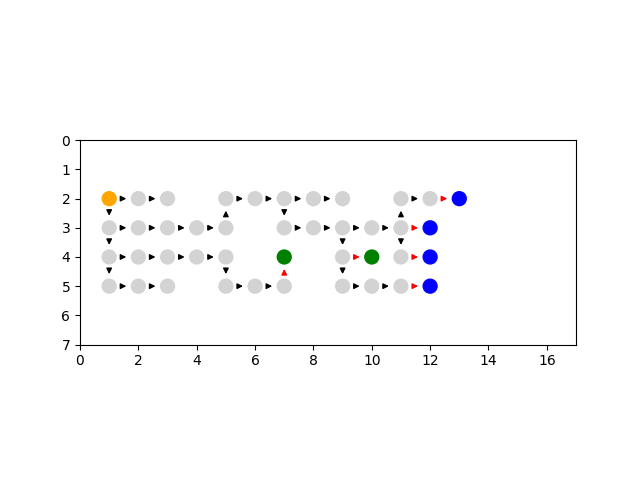

In [61]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

for node in nodes.values():
    G.add_node(node)
    for child in node.children:
        G.add_edge(node, child, kind="grow")
    for feature in node.features.values():
        G.add_edge(node, feature, kind="feature")

node_colormap = []
for node in G.nodes:
    if node.entity and node.entity.owner == Contestant.PLAYER:
        node_colormap.append("orange")
    elif node.entity and node.entity.owner == Contestant.OPPONENT:
        node_colormap.append("blue")
    elif node.entity and node.entity.kind in EntityKind.PROTEINS:
        node_colormap.append("green")
    else:
        node_colormap.append("lightgray")

edge_colormap = []
for edge in G.edges:
    if G.edges[edge]["kind"] == "grow":
        edge_colormap.append("black")
    else:
        edge_colormap.append("red")

pos = {node: node.coord for node in nodes.values()}


# add axis
fig, ax = plt.subplots()
nx.draw_networkx_nodes(
    G,
    pos=pos,
    node_size=100,
    ax=ax,
    node_color=node_colormap,  # type: ignore
)
nx.draw_networkx_edges(
    G,
    pos,
    ax=ax,
    width=1,
    arrowstyle="-|>",
    arrowsize=8,
    edge_color=edge_colormap,  # type: ignore
)
plt.axis("on")
ax.set_xlim(0, width - 1)
ax.set_ylim(height - 1, 0)
ax.set_aspect("equal")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()